In [1]:
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text

from transformers import GPT2Tokenizer
import json
from create_errors import introduce_errors
import aspell

/home/petr/Plocha/DP/czech-gec/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-25 13:17:13.033090: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 13:17:13.035047: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 13:17:13.072339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 13:17:13.073527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performanc

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("lchaloupsky/czech-gpt2-medical")
special_tokens_dict = {'additional_special_tokens': ['[START]','[END]']} # 250104, 250105 # 50257, 50258
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

VOCAB_SIZE = tokenizer.vocab_size + 2

In [4]:
start_id, end_id = tokenizer(tokenizer.all_special_tokens[-2:])['input_ids']
start_id, end_id = start_id[0], end_id[0]

In [5]:
with open('config.json') as json_file:
    config = json.load(json_file)

In [6]:
MAX_LENGTH = config['max_length']
lang = config['lang']
token_file = config['token_file']
tokens = introduce_errors.get_token_vocabulary(token_file)
characters = introduce_errors.get_char_vocabulary(lang)
aspell_speller = aspell.Speller('lang', lang)
token_err_distribution = config['token_err_distribution']
char_err_distribution = config['char_err_distribution']
token_err_prob = config['token_err_prob']   
char_err_prob = config['char_err_prob']

In [7]:
SHUFFLE_BUFFER = config['shuffle_buffer']
BATCH_SIZE_PER_REPLICE = config['batch_size_per_replica']

In [8]:
print(f"Batch size per replica: {BATCH_SIZE_PER_REPLICE}")
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: %d' % strategy.num_replicas_in_sync)
BATCH_SIZE = BATCH_SIZE_PER_REPLICE * strategy.num_replicas_in_sync

Batch size per replica: 1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [9]:
class GenereteErrorLine():

    def __init__(self, tokens, characters, aspell_speller, token_err_distribution, char_err_distribution, token_err_prob, char_err_prob, token_std_dev=0.2, char_std_dev=0.01):
        self.tokens = tokens
        self.characters = characters
        self.aspell_speller = aspell_speller
        self.token_err_distribution = token_err_distribution
        self.char_err_distribution = char_err_distribution
        self.token_err_prob = token_err_prob
        self.token_std_dev = token_std_dev
        self.char_err_prob = char_err_prob
        self.char_std_dev = char_std_dev

    def __call__(self, line):
        line = line.decode('utf-8')
        token_replace_prob, token_insert_prob, token_delete_prob, token_swap_prob, recase_prob = self.token_err_distribution
        char_replace_prob, char_insert_prob, char_delete_prob, char_swap_prob, change_diacritics_prob = self.char_err_distribution
        line = line.strip('\n')
        
        # introduce word-level errors
        line = introduce_errors.introduce_token_level_errors_on_sentence(line.split(' '), token_replace_prob, token_insert_prob, token_delete_prob,
                                                        token_swap_prob, recase_prob, float(self.token_err_prob), float(self.token_std_dev),
                                                        self.tokens, self.aspell_speller)
        if '\t' in line or '\n' in line:
            raise ValueError('!!! Error !!! ' + line)
        # introduce spelling errors
        line = introduce_errors.introduce_char_level_errors_on_sentence(line, char_replace_prob, char_insert_prob, char_delete_prob, char_swap_prob,
                                                       change_diacritics_prob, float(self.char_err_prob), float(self.char_std_dev),
                                                       self.characters)
        return line
    
gel = GenereteErrorLine(tokens, characters, aspell_speller, token_err_distribution, char_err_distribution, token_err_prob, char_err_prob)

In [10]:
def get_tokenized_sentences(error_line, label_line):
    error_line = error_line.decode('utf-8')
    label_line = label_line.decode('utf-8')

    tokenized = tokenizer(error_line, text_target=label_line, padding='max_length', truncation=True, return_tensors="tf")
    
    input_ids = tokenized['input_ids'][0]
    labels = tokenized['labels'][0]
    decoder_input_ids = tokenized['labels'][0]

    input_ids = tf.concat([[start_id], input_ids, [end_id]], 0)
    labels = tf.concat([labels, [end_id]], 0)
    decoder_input_ids = tf.concat([[start_id], decoder_input_ids], 0)

    input_ids = tf.keras.utils.pad_sequences([input_ids], maxlen=MAX_LENGTH, padding='post')[0]
    labels = tf.keras.utils.pad_sequences([labels], maxlen=MAX_LENGTH, padding='post')[0]
    decoder_input_ids = tf.keras.utils.pad_sequences([decoder_input_ids], maxlen=MAX_LENGTH, padding='post')[0]

    return input_ids, labels, decoder_input_ids
    # return (input_ids, labels), decoder_input_ids
def create_error_line(line):
    error_line = tf.numpy_function(gel, inp=[line], Tout=[tf.string])[0]
    label_line = line
    input_ids, labels, decoder_input_ids = tf.numpy_function(get_tokenized_sentences, inp=[error_line, label_line], Tout=[tf.int32, tf.int32, tf.int32])

    dato = {
        'input_ids': input_ids,
        'decoder_input_ids': decoder_input_ids,
        'labels': labels
    }
    return dato

def ensure_shapes(input_dict):
    return {key: tf.ensure_shape(val, (MAX_LENGTH)) for key, val in input_dict.items()}

def split_features_and_labels(input_batch):
    features = {key: tensor for key, tensor in input_batch.items() if key in ['input_ids', 'attention_mask', 'decoder_input_ids']}
    labels = {key: tensor for key, tensor in input_batch.items() if key in ['labels']}
    if len(features) == 1:
        features = list(features.values())[0]
    if len(labels) == 1:
        labels = list(labels.values())[0]
    if isinstance(labels, dict) and len(labels) == 0:
        return features
    else:
        return (features['input_ids'], features['decoder_input_ids']), labels


In [11]:
sentences = [
    "Mam rad sveho psa",
    "Nemam rad kocky",
    "Mam rad moji maminku",
    "Nehraju hry na pocitaci"
]

dataset = tf.data.Dataset.from_tensor_slices(sentences)
dataset = dataset.map(create_error_line, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(ensure_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(split_features_and_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# dataset = dataset.ignore_errors()
dataset = dataset.shuffle(SHUFFLE_BUFFER)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
for d in dataset.take(1):
    break
d[1]

2023-04-25 13:17:17.332327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]
2023-04-25 13:17:17.332639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maxi

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  978,  1139,  2433, 21445,   311,  3114,  1510, 50258,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

---

In [13]:
def positional_encoding(length, depth):
    depth = depth / 2 
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)   
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)    
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [14]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)   

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)   
    
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [15]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True) 
        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores   
        x = self.add([x, attn_output])
        x = self.layernorm(x) 
        return x

In [16]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [17]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [18]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)


In [19]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()   

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [20]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()    
        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate) 
        self.ffn = FeedForward(d_model, dff)  
    
    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [21]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()    
        self.d_model = d_model
        self.num_layers = num_layers  
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)   
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [22]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
        super(DecoderLayer, self).__init__()    
        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)   
        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)   
        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
    
        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores
    
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [23]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__() 
        self.d_model = d_model
        self.num_layers = num_layers    
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                 d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)] 
        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    
        x = self.dropout(x)
    
        for i in range(self.num_layers):
          x  = self.dec_layers[i](x, context)
    
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    
        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [24]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        cz_error, cz = inputs
    
        sample_encoder_output = self.encoder(cz_error)  # (batch_size, context_len, d_model)
    
        x = self.decoder(cz, sample_encoder_output)  # (batch_size, target_len, d_model)
    
        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)
    
        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass
      
        # Return the final output and the attention weights.
        return logits

---

In [25]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [26]:
for d in dataset.take(1):
    break
dato, label = d

2023-04-25 13:17:17.787121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]
2023-04-25 13:17:17.787435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]


In [27]:
encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=VOCAB_SIZE,
                               dropout_rate=dropout_rate)

In [28]:
sample_encoder_output = encoder(dato[0])

In [29]:
decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=VOCAB_SIZE,
                               dropout_rate=dropout_rate)

x = decoder(dato[1], sample_encoder_output) 

In [30]:
final_layer = tf.keras.layers.Dense(VOCAB_SIZE)
final_layer(x)

<tf.Tensor: shape=(1, 128, 50259), dtype=float32, numpy=
array([[[ 6.40365761e-03, -6.30999655e-02,  2.61963345e-02, ...,
         -1.27140716e-01, -4.50231284e-02, -5.07379435e-02],
        [-8.81408900e-02,  1.40718091e-02,  4.82797027e-02, ...,
         -5.17475083e-02, -6.11211034e-03,  3.59551758e-02],
        [-7.75378523e-03,  3.70544456e-02, -5.54763786e-02, ...,
         -9.28372219e-02,  8.34602639e-02,  7.21014217e-02],
        ...,
        [ 1.94065049e-01, -9.58290175e-02,  9.18215066e-02, ...,
          3.15091461e-02,  5.22802509e-02, -1.16589218e-01],
        [ 1.60165101e-01, -8.60422924e-02,  6.69383779e-02, ...,
          2.51024589e-02,  6.65339306e-02, -1.18709333e-01],
        [ 1.34065270e-01, -9.17544886e-02,  6.38262555e-02, ...,
         -4.88399564e-05,  7.37682208e-02, -1.07833385e-01]]],
      dtype=float32)>

In [31]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=VOCAB_SIZE,
    target_vocab_size=VOCAB_SIZE,
    dropout_rate=dropout_rate)


In [32]:
transformer(dato)
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  9072000   
                                                                 
 decoder_1 (Decoder)         multiple                  11182976  
                                                                 
 dense_33 (Dense)            multiple                  6483411   
                                                                 
Total params: 26,738,387
Trainable params: 26,738,387
Non-trainable params: 0
_________________________________________________________________


In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

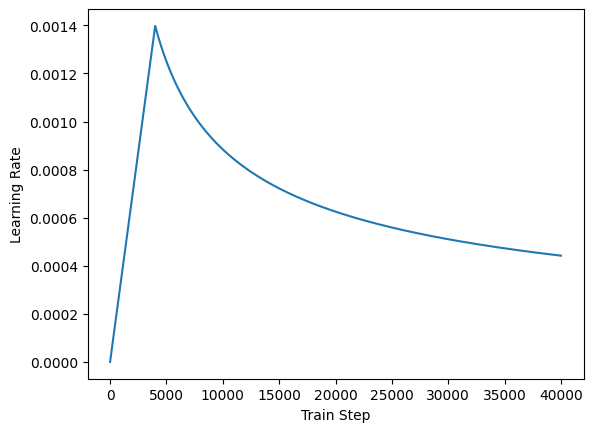

In [34]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [35]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    
    mask = label != 0
    
    match = match & mask
    
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [36]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])


In [37]:
transformer.fit(dataset)

2023-04-25 13:17:21.943912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]
2023-04-25 13:17:21.944116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 13s 382ms/step - loss: 10.8343 - masked_accuracy: 0.0000e+00
